### Install Requirements

In [6]:
! pip install apache_beam[gcp]>=2.44.0  
! pip install transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 100.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 110.0 MB/s eta 0:00:00


#### Check for Machine-type

In [1]:
! nvidia-smi

Tue May 30 12:57:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#### Load and Visualize Images

In [2]:
images_url = ['https://storage.googleapis.com/apache-beam-samples/image_captioning/Paris-sunset.jpeg',
              'https://storage.googleapis.com/apache-beam-samples/image_captioning/Wedges.jpeg',
              'https://storage.googleapis.com/apache-beam-samples/image_captioning/Hamsters.jpeg',
              'https://storage.googleapis.com/apache-beam-samples/image_captioning/cat_with_hat.jpg',
              'https://storage.googleapis.com/apache-beam-samples/image_captioning/Cat-with-beanie.jpg'
              ]

In [3]:
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import os
import requests

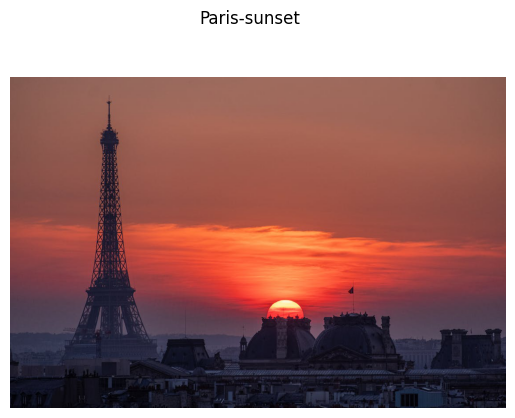

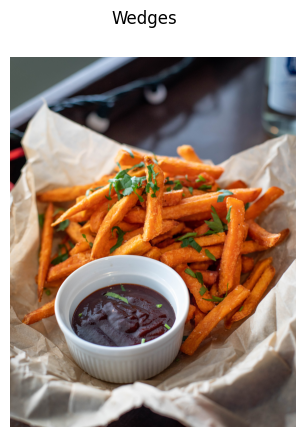

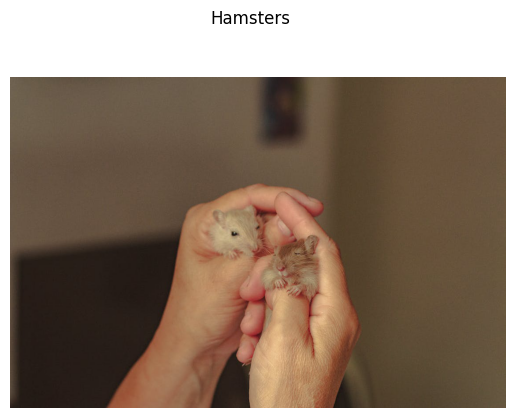

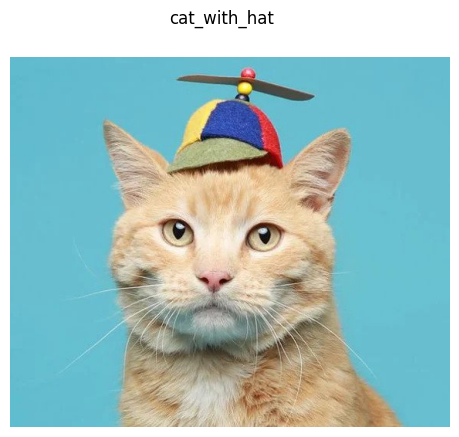

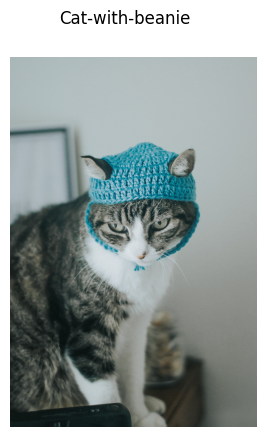

In [4]:
for image_url in images_url:
  response = requests.get(image_url)
  image = Image.open(BytesIO(response.content)).convert('RGB')
  fig = plt.figure()
  title = f"{os.path.basename(image_url).rsplit('.')[0]}"
  fig.suptitle(title, fontsize=12)
  plt.axis('off')
  plt.imshow(image)

#### Develop Pipeline for Image Captioning and Ranking

In [7]:
import apache_beam as beam
from apache_beam.options.pipeline_options import PipelineOptions
from apache_beam.options.pipeline_options import SetupOptions
from apache_beam.ml.inference.base import RunInference
from apache_beam.ml.inference.base import KeyedModelHandler
from apache_beam.ml.inference.pytorch_inference import PytorchModelHandlerTensor, PytorchModelHandlerKeyedTensor
from apache_beam.ml.inference.pytorch_inference import make_tensor_model_fn, _convert_to_device, TensorInferenceFn
from apache_beam.ml.inference import utils
from apache_beam.ml.inference.base import PredictionResult

import torch
import numpy as np

from transformers import AutoConfig
from transformers import BlipProcessor, BlipForConditionalGeneration
from transformers import CLIPProcessor, CLIPModel

from typing import Tuple
from typing import List
from typing import Any
from typing import Callable
from typing import Dict
from typing import Iterable
from typing import Optional
from typing import Sequence

#### BLIP Pre-process and Post-Process

In [9]:
def read_img_from_url(img_url: str):
  image = Image.open(requests.get(img_url, stream=True).raw)
  return img_url, image


def blip_preprocess(image: Image.Image, processor: BlipProcessor):
  inputs = processor(images=image, return_tensors="pt")
  return inputs.pixel_values

class BLIPPostprocess(beam.DoFn):
  def __init__(self, processor: BlipProcessor):
    self._processor = processor
  
  def process(self, element):
    img_url, output = element
    captions = blip_processor.batch_decode(output.inference, skip_special_tokens=True)
    yield img_url, captions


#### CLIP Pre-process and Post-Process

In [11]:
class CLIPPreprocess(beam.DoFn):
  def __init__(self, processor: CLIPProcessor):
    self._processor = processor
  
  def process(self, element):
    img_url, grouped_val = element
    pil_img, captions = grouped_val['image'], grouped_val['captions'][0]
    processed_output = self._processor(text=captions, images=pil_img, return_tensors="pt", padding=True)
    # print(processed_output)
    yield (img_url, captions), processed_output


class CLIPPostProcess(beam.DoFn):
  def __init__(self, processor: CLIPProcessor):
    self._processor = processor
  
  def process(self, element):
    (image_url, captions), prediction = element
    prediction_results = prediction.inference
    prediction_probs = prediction_results.softmax(dim=-1).cpu().detach().numpy()
    ranking = np.argsort(-prediction_probs)
    sorted_caption_prob_pair = [(captions[idx], prediction_probs[idx]) for idx in ranking]
    return [(image_url, sorted_caption_prob_pair)]


class FormatCaptions(beam.DoFn):
  """
  Print the image name and its most relevant captions after CLIP ranking.
  """
  def __init__(self, number_of_top_captions: int):
    self._number_of_top_captions = number_of_top_captions

  def process(self, element: Tuple[str, List[str]]):
    image_url, caption_list = element
    caption_list = caption_list[:self._number_of_top_captions]
    img_name = os.path.basename(image_url).rsplit('.')[0]
    print(f'Image: {img_name}')
    print(f'\tTop {self._number_of_top_captions} captions ranked by CLIP:')
    for caption_rank, caption_prob_pair in enumerate(caption_list):
      print(f"""\t\t{caption_rank+1}: {caption_prob_pair[0]}. 
      (Caption probability: {caption_prob_pair[1]:.4f})""")
    print('\n')


##### Download weights(state-dict) of BLIP and CLIP Model 

In [19]:
local_blip_state_dict_path = "./blip_model.pth"
blip_model_id = "Salesforce/blip-image-captioning-base"
blip_processor = BlipProcessor.from_pretrained(blip_model_id)
blip_model = BlipForConditionalGeneration.from_pretrained(blip_model_id)
torch.save(blip_model.state_dict(), local_blip_state_dict_path)

In [20]:
local_clip_state_dict_path = "./clip_model.pth"
clip_model_id = "openai/clip-vit-base-patch32"
clip_processor = CLIPProcessor.from_pretrained(clip_model_id)
clip_model = CLIPModel.from_pretrained(clip_model_id)
torch.save(clip_model.state_dict(), local_clip_state_dict_path)

In [16]:
def mod_make_tensor_model_fn(model_fn: str) -> TensorInferenceFn:
  """
  Produces a TensorInferenceFn that uses a method of the model other that
  the forward() method.

  Args:
    model_fn: A string name of the method to be used. This is accessed through
      getattr(model, model_fn)
  """
  def attr_fn(
      batch: Sequence[torch.Tensor],
      model: torch.nn.Module,
      device: str,
      inference_args: Optional[Dict[str, Any]] = None,
      model_id: Optional[str] = None,
  ) -> Iterable[PredictionResult]:
    with torch.no_grad():
      batched_tensors = torch.stack(batch)
      batched_tensors = _convert_to_device(torch.squeeze(batched_tensors,0), device) # Changed this line to remove extra dimension
      pred_fn = getattr(model, model_fn)
      predictions = pred_fn(batched_tensors, **inference_args)
      return utils._convert_to_result(batched_tensors, torch.unsqueeze(predictions,0), model_id) # Changed this line to add extra dimension for prediction
  return attr_fn

In [17]:
gen_fn = mod_make_tensor_model_fn('generate')

In [21]:
blip_model_handler = PytorchModelHandlerTensor(
    state_dict_path=local_blip_state_dict_path,
    model_class=BlipForConditionalGeneration,
    model_params={
        "config": AutoConfig.from_pretrained(blip_model_id)
    },
    max_batch_size=1,
    device = "gpu",
    inference_fn=gen_fn)

In [22]:
class CLIPWrapper(CLIPModel):

  def forward(self, **kwargs: Dict[str, torch.Tensor]):
    # Squeeze because RunInference adds an extra dimension, which is empty.
    kwargs = {key: tensor.squeeze(0) for key, tensor in kwargs.items()}
    output = super().forward(**kwargs)
    logits = output.logits_per_image
    return logits


clip_model_handler = PytorchModelHandlerKeyedTensor(
    state_dict_path=local_clip_state_dict_path,
    model_class=CLIPWrapper,
    model_params={
        "config": AutoConfig.from_pretrained(clip_model_id)
    },
    max_batch_size=1,)

<ipython-input-22-21cc77425c3a>:11: FutureWarning: PytorchModelHandlerKeyedTensor is experimental. No backwards-compatibility guarantees.
  clip_model_handler = PytorchModelHandlerKeyedTensor(


In [24]:
with beam.Pipeline() as pipeline:

  img_url_pil_img = (
            pipeline 
            | "ReadUrl" >> beam.Create(images_url)
            | "ReadImages" >> beam.Map(read_img_from_url))
  img_url_captions = (
            img_url_pil_img
            | "BLIPPreprocess" >> beam.MapTuple(lambda img_url, img: (img_url, blip_preprocess(img, processor=blip_processor)))
            | "GenerateCaptions" >> RunInference(model_handler=KeyedModelHandler(blip_model_handler), 
                                                 inference_args={"max_length": 50,
                                                                 "min_length": 10,
                                                                 "num_return_sequences":5, 
                                                                 "do_sample":True}
                                                 )
            | "BLIPPostProcess" >> beam.ParDo(BLIPPostprocess(processor=blip_processor)))
  img_url_captions_ranking = (
            ({'image' : img_url_pil_img, 'captions': img_url_captions})
            | "CreateImageCaptionPair" >> beam.CoGroupByKey()
            | "CLIPPreprocess" >> beam.ParDo(CLIPPreprocess(processor=clip_processor))
            | "CaptionRanking" >> RunInference(model_handler=KeyedModelHandler(clip_model_handler))
            | "CLIPPostProcess" >> beam.ParDo(CLIPPostProcess(processor=clip_processor))

  )

  img_url_captions_ranking | "FormatCaptions" >> beam.ParDo(FormatCaptions(3))


/usr/local/lib/python3.10/dist-packages/dill/_dill.py:472: FutureWarning: PytorchModelHandlerKeyedTensor is experimental. No backwards-compatibility guarantees.
  obj = StockUnpickler.load(self)
/usr/local/lib/python3.10/dist-packages/dill/_dill.py:472: FutureWarning: PytorchModelHandlerKeyedTensor is experimental. No backwards-compatibility guarantees.
  obj = StockUnpickler.load(self)


Image: Paris-sunset
	Top 3 captions ranked by CLIP:
		1: a colorful sunset over the eiff tower and the eiffiff tower in paris. 
      (Caption probability: 0.4555)
		2: paris sunset over the parisian quarter, seen from the jar d'ais photo by alex jani. 
      (Caption probability: 0.2321)
		3: a view of the eiffure tower in paris at sunset. 
      (Caption probability: 0.1727)


Image: Wedges
	Top 3 captions ranked by CLIP:
		1: a bowl of freshly cooked plant fries with a small kernin sauce. 
      (Caption probability: 0.9520)
		2: french fries with sauce and dip to make something go along. 
      (Caption probability: 0.0412)
		3: a stack of baked potato fries and a cup of kessii sauce. 
      (Caption probability: 0.0054)


Image: Hamsters
	Top 3 captions ranked by CLIP:
		1: a baby hamster is sitting in the woman's hand. 
      (Caption probability: 0.5027)
		2: woman holding small and fluffy looking brown hamie in a hand. 
      (Caption probability: 0.4755)
		3: a woman holding a